<a href="https://colab.research.google.com/github/schuhf/schuhf/blob/main/CBA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotnine

In [ ]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
# Import the data from Google Drive
cba_data = pd.read_csv('/content/drive/MyDrive/Hydroeconomic Course/data_cba.csv', sep = ';', encoding="utf8")

## Cleaning data
cba_data = cba_data[['Year','Sector','Scenario 0','Scenario 1','Scenario 2','Scenario 3']] #select columns
cba_data = cba_data.dropna() # drop missing lines (file structure)

cba_data[['Scenario 0','Scenario 1','Scenario 2','Scenario 3']] = cba_data[['Scenario 0','Scenario 1','Scenario 2','Scenario 3']].apply(lambda x: x.replace(',','', regex = True).astype(float))

## Discounting based on Scenario 0
cba_data['Scenario 1'] = cba_data['Scenario 1'] - cba_data['Scenario 0']
cba_data['Scenario 2'] = cba_data['Scenario 2'] - cba_data['Scenario 0']
cba_data['Scenario 3'] = cba_data['Scenario 3'] - cba_data['Scenario 0']
cba_data = cba_data.drop(['Scenario 0'], axis = 1)

## Melting based on scenario
cba_data_m = pd.melt(cba_data, id_vars = ['Year','Sector'], value_vars = [ 'Scenario 1', 'Scenario 2', 'Scenario 3'], var_name = 'Scenario', value_name = 'Net_Benefit')


In [ ]:
### Costs, Benefits and Present_Value
from plotnine import *

cba_data_base = cba_data_m

## Create base df for Present Value
n = np.arange(0,31,1, dtype = int)
years = np.arange(2020,2051,1, dtype = int)
df_rate = pd.DataFrame(np.column_stack((n, years)), columns = ['n','Year'])

## Merge
cba_data_base = cba_data_base.merge(df_rate, on = ['Year'], how = 'left')

## Define discount rate
r = 6

## Compute Present Value
cba_data_base['rate_n'] = np.power(float(1 + (r/100)), cba_data_base['n'])
cba_data_base['Present_Value'] = cba_data_base['Net_Benefit'] / cba_data_base['rate_n']

# Compute Costs and Benefits per Scenario
costs = cba_data_base[cba_data_base['Sector'] == 'Costs dam building'].groupby(['Scenario']).Present_Value.sum().reset_index().rename(columns={'Present_Value': 'costs_'})
benefits = cba_data_base[cba_data_base['Sector'] != 'Costs dam building'].groupby(['Scenario']).Present_Value.sum().reset_index().rename(columns={'Present_Value': 'benefits_'})

## Cost Benefit Analysis
c_b = costs.merge(benefits, on = 'Scenario', how = 'left')
c_b['NPV'] = np.round(c_b['benefits_'] - c_b['costs_'],2) / 1000
c_b['Costs'] = c_b['costs_'] / 1000
c_b['Benefits'] = c_b['benefits_'] / 1000
c_b['b_c_ratio'] = np.round(c_b['benefits_'] / c_b['costs_'],2)

c_b

In [ ]:
### Costs, Benefits and NPV Plot
import plotnine
from plotnine import *
## Data processing
c_b_plot = c_b.drop(['costs_','benefits_','b_c_ratio'], axis = 1)
c_b_plot = pd.melt(c_b_plot, id_vars = ['Scenario'], value_vars = ['Costs','Benefits','NPV'], var_name = 'Variable', value_name = 'Value')
c_b_plot['Value'] = np.round(c_b_plot['Value'],2)

## Plotting

fig, plot = (plotnine.ggplot(c_b_plot) # data
  + aes(x = 'Scenario', y = 'Value', fill = 'Scenario')
  + geom_bar(stat = 'identity', position = 'dodge')
  + geom_text(aes(label = 'Value', group = 1), size = 12, nudge_x = 0, nudge_y = -2)
  + facet_wrap('Variable', ncol = 3)
  + scale_y_continuous(limits = (0,1000), expand=(0.05, 0, 0.15, 0))
  + labs(x = 'Scenarios', y = 'Present Values ($ thousands)', title = str('Cost-Benefit Analysis (r = ' + str(r) + '%)'))
  + theme_bw()
  + theme(figure_size = (9,4))).draw(show=False, return_ggplot=True)

plt.show()



In [ ]:
## Sensitivity Analysis (PLOTS)
from plotnine import *

cba_data_s = cba_data_m

## Create base df for Present Value
n = np.arange(0,31,1, dtype = int)
years = np.arange(2020,2051,1, dtype = int)
df_rate = pd.DataFrame(np.column_stack((n, years)), columns = ['n','Year'])

## Merge
cba_data_s = cba_data_s.merge(df_rate, on = ['Year'], how = 'left')

## Discount rate options
drates = np.arange(-1,11,1, dtype = int)

## Loop over to save plots
for r in drates:
  
  cba_data_s['rate_n'] = np.power(float(1 + (r/100)), cba_data_s['n'])
  cba_data_s['Present_Value'] = cba_data_s['Net_Benefit'] / cba_data_s['rate_n']

  grouped_df = cba_data_s.groupby(['Sector','Scenario']).Present_Value.sum().reset_index()
  grouped_df['Scenario'] = grouped_df['Scenario'].replace('Scenario ','', regex = True)
  grouped_df['PV_Thousands'] = np.round((grouped_df['Present_Value'] / 1000), 1)  

  fig, plot = ( plotnine.ggplot(grouped_df) # data
    + aes(x = 'Scenario', y = 'PV_Thousands', fill = 'Scenario')
    + geom_bar(stat = 'identity')
    + geom_text(aes(label = 'PV_Thousands'), size = 7)
    + facet_wrap('Sector', ncol = 2)
    + scale_y_continuous(limits = (-250,1500))
    + labs(x = 'Scenario and Sectors', y = 'Present Values ($ thousands)', title = str('Cost-Benefit Analysis (r = ' + str(r) + '%)'))
    + theme_bw()
    + theme(figure_size = (7,7))).draw(show=False, return_ggplot=True)
  
  fig.savefig(str('/content/drive/MyDrive/Hydroeconomic Course/CBA Results/Sectoral CBA Plots/' + str(r) + '.png'), dpi = 500)

In [ ]:
## Line Plot over Years
## Sensitivity Analysis (PLOTS)
from plotnine import *

cba_data_s = cba_data_m

## Create base df for Present Value
n = np.arange(0,31,1, dtype = int)
years = np.arange(2020,2051,1, dtype = int)
df_rate = pd.DataFrame(np.column_stack((n, years)), columns = ['n','Year'])

## Merge
cba_data_s = cba_data_s.merge(df_rate, on = ['Year'], how = 'left')

## Discount rate options
drates = [0, 2, 4, 6 , 7, 8]

## Loop over to save plots
for r in drates:
  
  cba_data_s = cba_data_s[~cba_data_s['Sector'].isin(['Costs dam building'])]
  cba_data_s['rate_n'] = np.power(float(1 + (r/100)), cba_data_s['n'])
  cba_data_s['Present_Value'] = cba_data_s['Net_Benefit'] / cba_data_s['rate_n']

  grouped_df = cba_data_s.groupby(['Sector','Scenario','Year']).Present_Value.sum().reset_index()
  grouped_df['PV_Thousands'] = np.round((grouped_df['Present_Value'] / 1000), 1)  

  fig, plot = ( plotnine.ggplot(grouped_df) # data
    + aes(x = 'Year', y = 'PV_Thousands', color = 'Sector')
    + geom_line()
     + facet_wrap('Scenario', ncol = 1)
    + labs(x = 'Sector', y = 'Present Values ($ thousands)', title = str('Present Values (r = ' + str(r) + '%)'))
    + scale_x_continuous(expand = (0,0))
    + theme_bw()
    + theme(figure_size = (11, 8), legend_position = (0,0.5), legend_title = element_blank())).draw(show=False, return_ggplot=True)
  
  fig.savefig(str('/content/drive/MyDrive/Hydroeconomic Course/CBA Results/Line Plots/' + str(r) + ' line.png'), dpi = 500)


In [ ]:
## Stacked Bar Plot over Years
## Sensitivity Analysis (PLOTS)
from plotnine import *

cba_data_s = cba_data_m

## Create base df for Present Value
n = np.arange(0,31,1, dtype = int)
years = np.arange(2020,2051,1, dtype = int)
df_rate = pd.DataFrame(np.column_stack((n, years)), columns = ['n','Year'])

## Merge
cba_data_s = cba_data_s.merge(df_rate, on = ['Year'], how = 'left')

## Discount rate options
drates = [0, 2, 4, 6 , 8]

## Loop over to save plots
for r in drates:
  
  cba_data_s = cba_data_s[~cba_data_s['Sector'].isin(['Costs dam building'])]
  cba_data_s['rate_n'] = np.power(float(1 + (r/100)), cba_data_s['n'])
  cba_data_s['Present_Value'] = cba_data_s['Net_Benefit'] / cba_data_s['rate_n']

  grouped_df = cba_data_s.groupby(['Sector','Scenario','Year']).Present_Value.sum().reset_index()
  grouped_df['PV_Thousands'] = np.round((grouped_df['Present_Value'] / 1000), 1)  

  fig, plot = ( plotnine.ggplot(grouped_df) # data
    + aes(x = 'Year', y = 'PV_Thousands', fill = 'Sector')
    + geom_col()
    + facet_wrap('Scenario', ncol = 1)
    + labs(x = 'Year', y = 'Present Values ($ thousands)', title = str('Present Values (r = ' + str(r) + '%)'))
    + theme_minimal()
    + theme(figure_size = (16, 8))).draw(show=False, return_ggplot=True)
  
  fig.savefig(str('/content/drive/MyDrive/Hydroeconomic Course/CBA Results/Stacked Bar/' + str(r) + ' line.png'), dpi = 500)


In [ ]:
## Sensitivity Analysis (CBA) - WORK IN PROGRESS
cba_data_s = cba_data_m
## Create base df for Present Value
n = np.arange(0,31,1, dtype = int)
years = np.arange(2020,2051,1, dtype = int)
df_rate = pd.DataFrame(np.column_stack((n, years)), columns = ['n','Year'])

## Merge
cba_data_s = cba_data_s.merge(df_rate, on = ['Year'], how = 'left')

## Discount rate options
drates = np.arange(-1,11,1, dtype = int)

cba_list = list()

## Loop over to save plots
for r in drates:
  
  cba_data_s['rate_n'] = np.power(float(1 + (r/100)), cba_data_s['n'])
  cba_data_s['Present_Value'] = cba_data_s['Net_Benefit'] / cba_data_s['rate_n']

  costs = cba_data_s[cba_data_s['Sector'] == 'Costs dam building'].groupby(['Scenario']).Present_Value.sum().reset_index().rename(columns={'Present_Value': 'costs'})
  benefits = cba_data_s[cba_data_s['Sector'] != 'Costs dam building'].groupby(['Scenario']).Present_Value.sum().reset_index().rename(columns={'Present_Value': 'benefits'})

  c_b = costs.merge(benefits, on = 'Scenario', how = 'left')
  c_b['npv'] = np.round(c_b['benefits'] - c_b['costs'],2)
  c_b['b_c_ratio'] = np.round(c_b['benefits'] / c_b['costs'],2)
  c_b['rate_selected'] = r

  cba_list.append(c_b)

In [ ]:
## Concatenate list of dataframes
cba_list_concat = pd.concat(cba_list)
cba_list_concat.to_csv('/content/drive/MyDrive/Hydroeconomic Course/CBA Results/cba_sensitivity.csv')

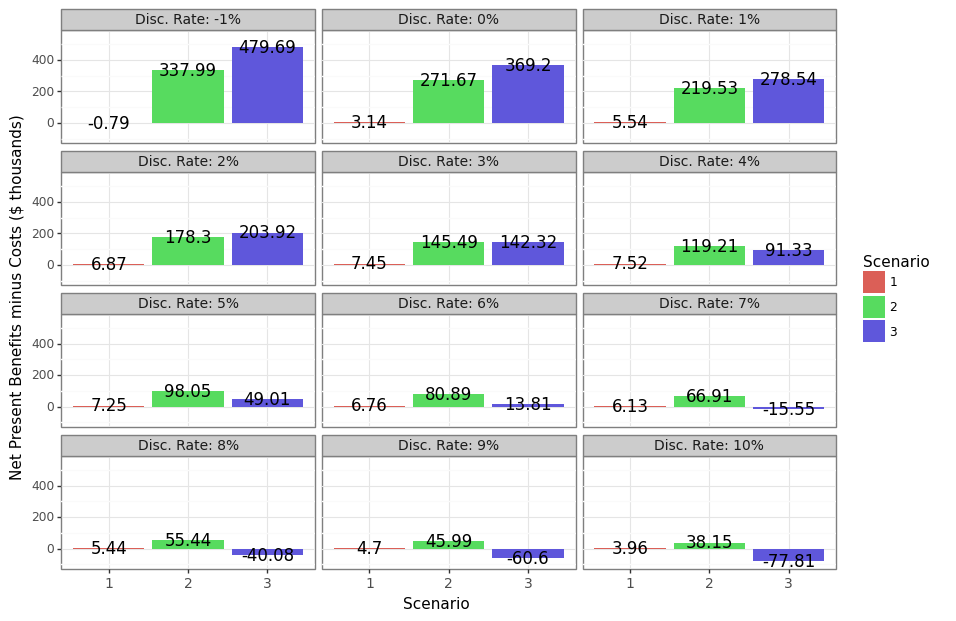

In [ ]:
## Plot Results CBA Sensitivity - NPV
from plotnine import *

## Discount rate options
drates = np.arange(-1,11,1, dtype = int)

## Data processing
cba_list_concat['npv_mil'] = np.round(cba_list_concat['npv'] / 1000 , 2)
cba_list_concat['rate_text'] = cba_list_concat['rate_selected'].apply(str)
cba_list_concat['rate_text'] = cba_list_concat['rate_text'].apply(lambda x: "Disc. Rate: {}%".format(x)).astype('category')
ordered_list = ["Disc. Rate: {}%".format(r) for r in drates]
cba_list_concat['rate_text'] = cba_list_concat['rate_text'].cat.reorder_categories(ordered_list)
cba_list_concat['Scenario'] = cba_list_concat['Scenario'].replace('Scenario ','', regex = True)

#Plotting
fig, plot = ( plotnine.ggplot(cba_list_concat) # data
    + aes(x = 'Scenario', y = 'npv_mil', fill = 'Scenario')
    + geom_bar(stat = 'identity')
    + geom_text(aes(label = 'npv_mil'), size = 12, color = 'black')
    + facet_wrap('rate_text', ncol = 3)
    + labs(x = 'Scenario', y = 'Net Present Benefits minus Costs ($ thousands)')
    + scale_y_continuous(limits = (-100,500), expand=(0.05, 0, 0.15, 0))
    + theme_bw()
    + theme(figure_size=(10, 7), axis_text_x = element_text(size = 10), strip_text_x = element_text(size = 10))).draw(show=False, return_ggplot=True)
    
  
fig.savefig(str('/content/drive/MyDrive/Hydroeconomic Course/CBA Results/npv_sensitivity.png'), dpi = 500)

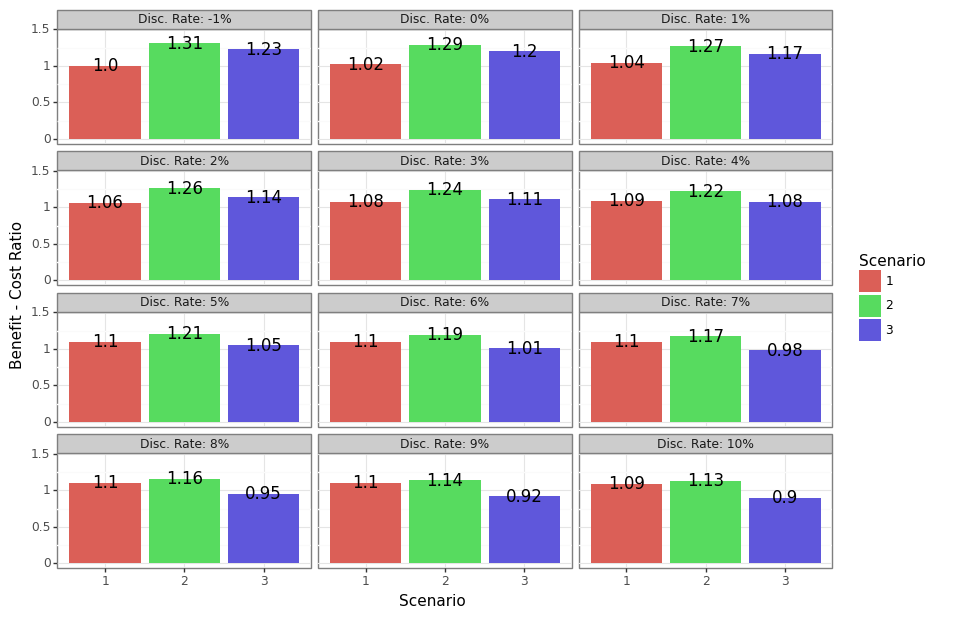

In [ ]:
## Plot Results CBA Sensitivity - BCR
from plotnine import *

cba_list_concat['npv_mil'] = np.round(cba_list_concat['npv'] / 1000 , 2)
cba_list_concat['rate_text'] = cba_list_concat['rate_selected'].apply(str)
cba_list_concat['rate_text'] = cba_list_concat['rate_text'].apply(lambda x: "Disc. Rate: {}%".format(x)).astype('category')
ordered_list = ["Disc. Rate: {}%".format(r) for r in drates]
cba_list_concat['rate_text'] = cba_list_concat['rate_text'].cat.reorder_categories(ordered_list)
cba_list_concat['Scenario'] = cba_list_concat['Scenario'].replace('Scenario ','', regex = True)

fig, plot = ( plotnine.ggplot(cba_list_concat) # data
    + aes(x = 'Scenario', y = 'b_c_ratio', fill = 'Scenario')
    + geom_bar(stat = 'identity')
    + geom_text(aes(label = 'b_c_ratio'), size = 12, color = 'black')
    + facet_wrap('rate_text', ncol = 3)
    + labs(x = 'Scenario', y = 'Benefit - Cost Ratio')
    + scale_y_continuous(expand=(0.05, 0, 0.15, 0))
    + theme_bw()
    + theme(figure_size=(10, 7))).draw(show=False, return_ggplot=True)
    
  
fig.savefig(str('/content/drive/MyDrive/Hydroeconomic Course/CBA Results/cbr_sensitivity.png'), dpi = 500)